<a href="https://colab.research.google.com/github/LIVECODING-2025/Saruto/blob/main/Analisis_Sentimen_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORT LIBRARY**

In [16]:
!pip install Sastrawi
!pip install emoji
!pip install wordcloud
!pip install nltk
!pip install transformers

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import emoji

from sklearn.model_selection import GridSearchCV
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn import model_selection
from sklearn import svm
from sklearn.svm import SVC

import time
import re
import nltk
import string

# **LOAD DATA DARI GOOGLE DRIVE**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_id = '/content/drive/MyDrive/Data Science/Live Coding 2025/komentar_berlabel.csv'

In [5]:
df = pd.read_csv(file_id)

In [6]:
label_mapping = {
    0: 'negatif',
    1: 'netral',
    2: 'positif'
}
df['sentiment'] = df['label'].map(label_mapping)

Text(0, 0.5, 'Frekuensi')

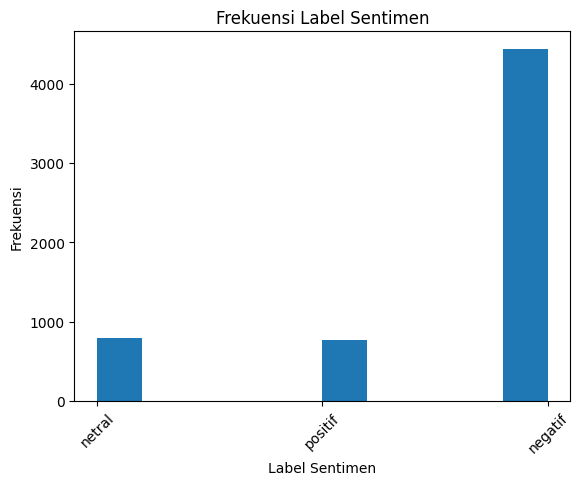

In [7]:
plt.hist(df.sentiment)
plt.xticks(rotation=45)
plt.title('Frekuensi Label Sentimen')
plt.xlabel('Label Sentimen')
plt.ylabel('Frekuensi')

# **PRE-PROCESING**

In [8]:
def case_folding(text):
    text = text.lower()
    return text
df['casefolding'] = df['komentar'].str.lower()

In [9]:
def remove_emojis_with_library(text):
    return emoji.demojize(text).encode('ascii', 'ignore').decode('utf8')

In [10]:
def cleansing(text):
    text = emoji.replace_emoji(text, replace='') #hapus emoji
    text = re.sub('\[.*?\]', '', text) #Menghilangkan tanda kurung
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Hapus karakter non-alfabet
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #Menghilangkan Tanda Baca
    text = re.sub('\w*\d\w*', '', text) #Menghilangkan Special Karakter
    text = re.sub('\s+[a-zA-Z]\s+', '', text) #Menghilangkan Single Character
    text = re.sub(r"http\S+", "", text, flags=re.MULTILINE) #Menghilangkan Link
    text = re.sub(r'\B#\S+','', text)  #Menghilangkan Hashtag
    text = re.sub(r'\s+', ' ', text, flags=re.I) #Mengganti Multiple Spaces ke Single Spaces
    text = text.strip() #Menghilangkan Spaces di awal
    text = text.translate(str.maketrans('', '', string.punctuation))  # Hapus tanda baca
    return text
df['cleansing'] = df['casefolding'].apply(cleansing)
df = df.dropna(subset=['cleansing'])  # Hapus NaN dulu
df = df[df['cleansing'].str.strip() != '']  # Hapus string kosong
df = df.reset_index(drop=True)  # Reset index

In [11]:
def tokenization(text):
    tokens = re.split(r'\W+', text)
    tokens = [word for word in tokens if word]
    return tokens

df['tokenizing'] = df['cleansing'].apply(tokenization)

In [22]:
factory = StopWordRemoverFactory()
list_stopwords = factory.get_stop_words()

def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]
df['stop_removal'] = df['tokenizing'].apply(stopwords_removal)

In [23]:
# stemmeing
start = time.time()
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi untuk stemming satu kata
def stemmed_wrapper(term):
    return stemmer.stem(term)

# Buat dictionary untuk menyimpan kata dan hasil stemming-nya
term_dict = {}

# Loop untuk isi term_dict
for document in df['stop_removal']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = stemmed_wrapper(term)

# Fungsi untuk mengganti setiap term dalam list dengan versi stemming-nya
def get_stemmed_term(document):
    return [term_dict.get(term, term) for term in document]  # Aman jika term tidak ada

# Apply ke DataFrame
df['stemming'] = df['stop_removal'].apply(get_stemmed_term)

# Tampilkan hasil
df.head()
print("Waktu eksekusi:", time.time() - start, "detik")

Waktu eksekusi: 1067.556052684784 detik


In [24]:
def normalisasi(document):
  return ' '.join(document)
df['normalisasi'] = df['stemming'].apply(normalisasi)
df.head()

,komentar,label,sentiment,casefolding,cleansing,tokenizing,stop_removal,stemming,normalisasi
0,Sangat keren! Meraih kemenangan besar di🚦𝐏 𝐋 𝐔...,1,netral,sangat keren! meraih kemenangan besar di🚦𝐏 𝐋 𝐔...,sangat keren meraih kemenangan besar di langsu...,"[sangat, keren, meraih, kemenangan, besar, di,...","[sangat, keren, meraih, kemenangan, besar, lan...","[sangat, keren, raih, menang, besar, langsung,...",sangat keren raih menang besar langsung libur ...
1,🔥𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥 memang layak jadi pilihan utama,2,positif,🔥𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥 memang layak jadi pilihan utama,memang layak jadi pilihan utama,"[memang, layak, jadi, pilihan, utama]","[memang, layak, jadi, pilihan, utama]","[memang, layak, jadi, pilih, utama]",memang layak jadi pilih utama
2,NYESEL PILIH PRABOWO,0,negatif,nyesel pilih prabowo,nyesel pilih prabowo,"[nyesel, pilih, prabowo]","[nyesel, pilih, prabowo]","[nyesel, pilih, prabowo]",nyesel pilih prabowo
3,ekspresinya so iye\npembahasannya walaweee,0,negatif,ekspresinya so iye\npembahasannya walaweee,ekspresinya so iye pembahasannya walaweee,"[ekspresinya, so, iye, pembahasannya, walaweee]","[ekspresinya, so, iye, pembahasannya, walaweee]","[ekspresi, so, iye, bahas, walaweee]",ekspresi so iye bahas walaweee
4,Yang komen kenapa parah banget literasinya?mes...,2,positif,yang komen kenapa parah banget literasinya?mes...,yang komen kenapa parah banget literasinyamesk...,"[yang, komen, kenapa, parah, banget, literasin...","[komen, parah, banget, literasinyameski, pwowo...","[komen, parah, banget, literasinyameski, pwowo...",komen parah banget literasinyameski pwowo lamb...


In [25]:
slang_dict = {
    'keren': 'bagus',
    'mantap': 'baik',
    'top': 'terbaik',
    'bagus banget': 'sangat baik',
    'respect': 'menghargai',
    'sangat setuju': 'setuju sekali',
    'hebat': 'luar biasa',
    'bangga': 'terhormat',
    'semangat': 'antusias',
    'cakep': 'bagus',
    'cocok': 'sesuai',
    'berkelas': 'berwibawa',
    'calon kuat': 'berpotensi',
    'gaskeun': 'lanjutkan',
    'the best': 'terbaik',
    'masuk akal': 'logis',
    'bijak': 'bijaksana',
    'kerennya': 'bagusnya',
    'dukungan penuh': 'mendukung sepenuhnya',

    'loh': '',
    'lho': '',
    'gimana': 'bagaimana',
    'kenapa': 'mengapa',
    'apa iya': 'apakah benar',
    'seriusan': 'serius',
    'emang': 'memang',
    'masa sih': 'tidak percaya',
    'btw': 'ngomong-ngomong',
    'wkwk': '', 'haha': '', 'hehe': '', 'lol': '',

    'bohong': 'tidak jujur',
    'omdo': 'omong doang',
    'pencitraan': 'membangun citra',
    'settingan': 'rekayasa',
    'gimik': 'trik',
    'nipu': 'menipu',
    'ga jelas': 'tidak jelas',
    'gagal': 'tidak berhasil',
    'zonk': 'mengecewakan',
    'lebay': 'berlebihan',
    'basi': 'tidak relevan',
    'alay': 'berlebihan',
    'toxic': 'berbahaya',
    'nyinyir': 'menghina',
    'julid': 'membenci',
    'sarkas': 'menyindir',
    'ngapain': 'mengapa',
    'aneh': 'tidak wajar',
    'asal ngomong': 'tidak berdasar',
    'ga niat': 'tidak serius',
    'caper': 'mencari perhatian',
    'ngebosenin': 'membosankan',
    'ngaco': 'tidak masuk akal',
    'hoax': 'berita palsu',

    'prabowo': 'prabowo subianto',
    'jkw': 'joko widodo',
    'ri': 'republik indonesia',
    'narsum': 'narasumber',
    'pemilu': 'pemilihan umum',
    'tni': 'tentara nasional indonesia',
    'polri': 'kepolisian republik indonesia',
    'capres': 'calon presiden',
    'cawapres': 'calon wakil presiden',
    'pres': 'presiden',
    'wkwkwk': '', 'wk': '', 'kwkwk': '',

    'ga': 'tidak',
    'gak': 'tidak',
    'nggak': 'tidak',
    'ngga': 'tidak',
    'aja': 'saja',
    'dong': '',
    'deh': '',
    'nih': '',
    'sih': '',
    'nya': '',
    'ya': '',
    'lah': '',
    'kok': '',
}

In [26]:
def normalize_text(text):
    if not isinstance(text, str):
        return ''

    # Proses frasa terlebih dahulu (kata yang terdiri dari lebih dari 1 kata)
    for slang, replacement in slang_dict.items():
        if ' ' in slang:  # hanya untuk frasa
            text = text.replace(slang, replacement)

    # Pisahkan sisa teks menjadi kata-kata
    words = text.split()

    # Normalisasi kata per kata
    normalized_words = [slang_dict.get(word.lower(), word) for word in words]

    return ' '.join(normalized_words)

df['normalisasi'] = df['normalisasi'].apply(normalize_text)

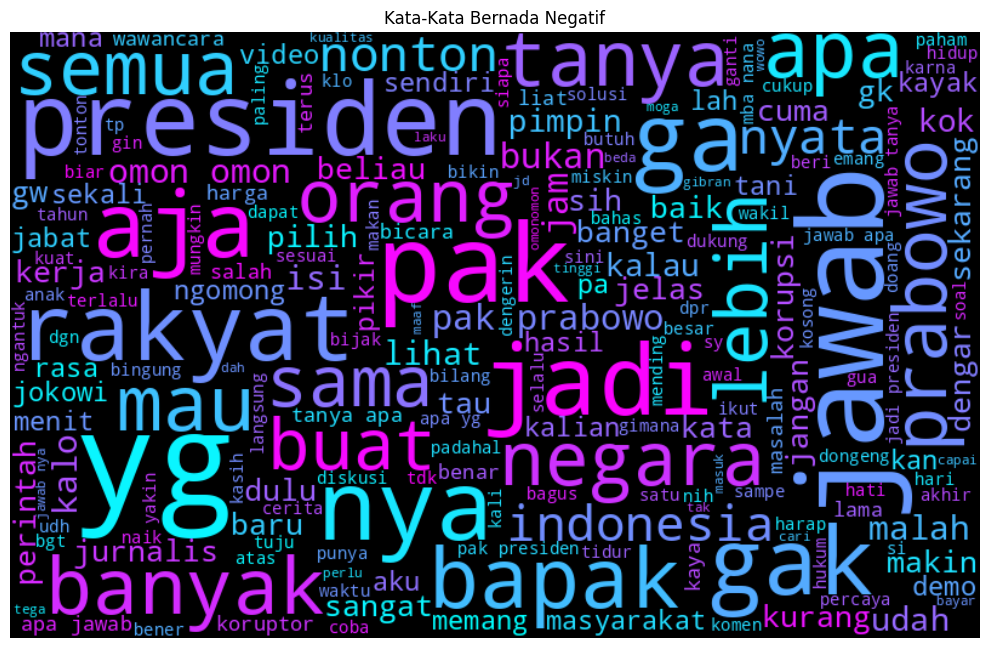

In [27]:
df_filtered = df[df['sentiment'] == 'negatif'].dropna(subset=['stemming'])
negative_words = ' '.join([word for sublist in df_filtered['stemming'] if isinstance(sublist, list) for word in sublist])

wordcloud = WordCloud(
    width=800,
    height=500,
    background_color='black',
    colormap='cool',
    max_font_size=110,
    random_state=0
).generate(negative_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Kata-Kata Bernada Negatif', color='black')
plt.tight_layout()
plt.show()

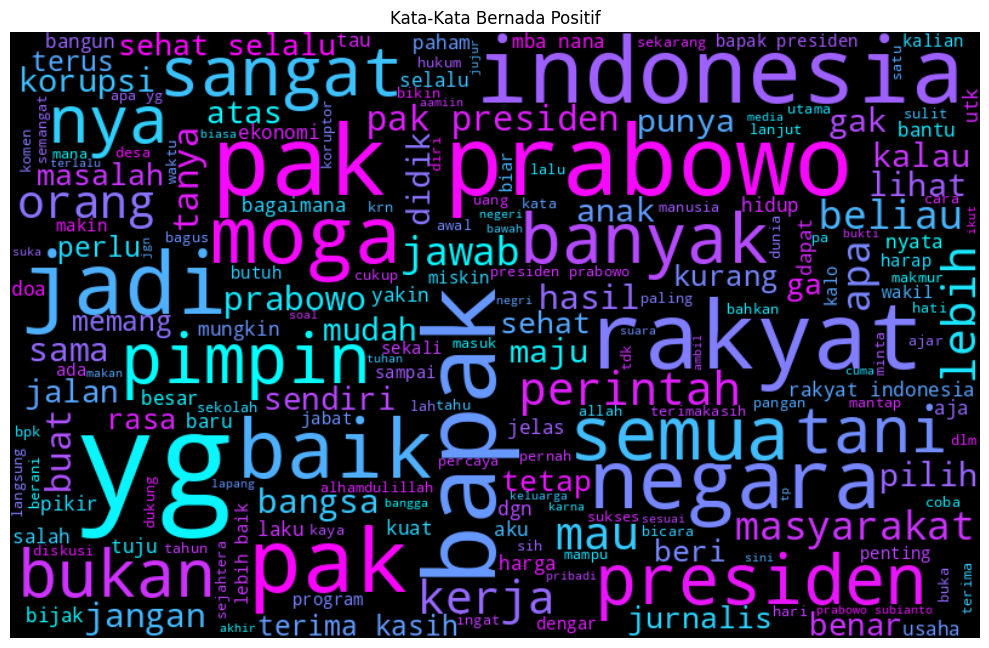

In [28]:
df_filtered = df[df['sentiment'] == 'positif'].dropna(subset=['stemming'])
positive_words = ' '.join([word for sublist in df_filtered['stemming'] if isinstance(sublist, list) for word in sublist])

wordcloud = WordCloud(
    width=800,
    height=500,
    background_color='black',
    colormap='cool',
    max_font_size=110,
    random_state=0
).generate(positive_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Kata-Kata Bernada Positif', color='black')
plt.tight_layout()
plt.show()

In [29]:
x = df['normalisasi']  # Teks hasil preprocessing
y = df['label']        # Label numerik: 0=Negatif, 1=Netral, 2=Positif

In [30]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x,y, test_size=0.2, random_state=42, stratify=y, shuffle=True,)

# **PEMBOBOTAN TF-IDF**

In [31]:
Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(x_train)

Train_X_Tfidf = Tfidf_vect.transform(x_train)
Test_X_Tfidf = Tfidf_vect.transform(x_test)

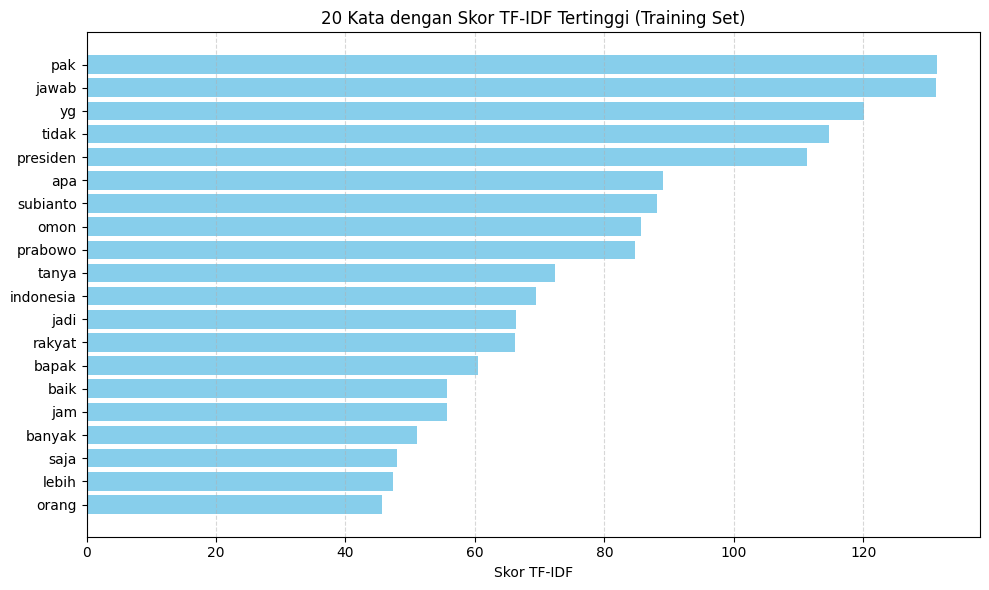

In [32]:
# Ambil nama-nama fitur (kata)
feature_names = Tfidf_vect.get_feature_names_out()

# Jumlahkan nilai TF-IDF untuk setiap kata di seluruh dokumen
tfidf_scores = np.asarray(Train_X_Tfidf.sum(axis=0)).flatten()

# Buat DataFrame
df_tfidf = pd.DataFrame({'Kata': feature_names, 'TF-IDF': tfidf_scores})

# Urutkan dan ambil 20 kata tertinggi
top_words = df_tfidf.sort_values(by='TF-IDF', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_words['Kata'][::-1], top_words['TF-IDF'][::-1], color='skyblue')
plt.xlabel('Skor TF-IDF')
plt.title('20 Kata dengan Skor TF-IDF Tertinggi (Training Set)')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [33]:
Train_X_Tfidf.shape

(4721, 8960)

In [34]:
y_train.shape

(4721,)

In [35]:
print(Train_X_Tfidf)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 53428 stored elements and shape (4721, 8960)>
  Coords	Values
  (0, 3758)	0.5167558153181092
  (0, 3767)	0.5167558153181092
  (0, 4540)	0.6825883493510803
  (1, 370)	0.23309438437359078
  (1, 580)	0.4222379242930495
  (1, 2154)	0.22665204052627555
  (1, 2259)	0.21693780128152695
  (1, 3437)	0.6199208781537134
  (1, 3633)	0.20968214029001908
  (1, 4023)	0.13820934280001387
  (1, 4435)	0.23309438437359078
  (1, 4691)	0.11549500924731317
  (1, 5907)	0.25310613218196193
  (1, 5913)	0.07934423435187203
  (1, 8167)	0.13959098677661527
  (1, 8662)	0.25310613218196193
  (2, 3408)	0.40937967801674463
  (2, 3841)	0.7992933062585309
  (2, 7200)	0.43993009648944537
  (3, 6509)	0.3011866750844636
  (3, 6754)	0.4884690296494037
  (3, 6948)	0.8189533526550433
  (4, 3130)	0.4488235648481555
  (4, 3254)	0.5932484067258658
  (4, 3390)	0.6024266331159116
  :	:
  (4716, 8178)	0.5891761820945086
  (4717, 7956)	0.652228154039915
  (4717, 8713)	0.

In [36]:
print(Test_X_Tfidf)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 12388 stored elements and shape (1181, 8960)>
  Coords	Values
  (0, 3038)	0.7148638556850166
  (0, 5206)	0.6313856440913471
  (0, 8905)	0.30053591510917016
  (1, 389)	0.08574410346597605
  (1, 948)	0.22148837453791959
  (1, 1287)	0.48624734443730777
  (1, 2952)	0.137757677260372
  (1, 3126)	0.16597696218014968
  (1, 3130)	0.11602526645584428
  (1, 3721)	0.15668664105673766
  (1, 4048)	0.19373266835903463
  (1, 4130)	0.22148837453791959
  (1, 4928)	0.16895267195898261
  (1, 5283)	0.1003259274653199
  (1, 5583)	0.1898381543246542
  (1, 5829)	0.10022174450314054
  (1, 5913)	0.06943263422364578
  (1, 5970)	0.22148837453791959
  (1, 6215)	0.1309531604608584
  (1, 6359)	0.18646457281862824
  (1, 6509)	0.3000659107307683
  (1, 6711)	0.08756684074557927
  (1, 7063)	0.11109719103489926
  (1, 7101)	0.2553349099653037
  (1, 7416)	0.13514179111756516
  :	:
  (1174, 6777)	0.31927879172190154
  (1174, 6892)	0.3478448170892895
  (1175, 577

# **SVM**

In [37]:
hyperparameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svm = SVC()
svm_tuned = GridSearchCV(svm, hyperparameters)

In [38]:
svm_tuned.fit(Train_X_Tfidf, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})

In [39]:
filename = 'model_svm_AS.pkl'
pickle.dump(svm_tuned.best_estimator_, open(filename, 'wb'))

In [40]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(Test_X_Tfidf, y_test)
print(result)

0.8314987298899238


# **EVALUASI**

In [41]:
# HASIL AKURASI, RECALL, PRECISSION, F1 SCORE
y_pred = loaded_model.predict(Test_X_Tfidf)

print("SVM Accuracy Score = ", accuracy_score(y_test, y_pred)*100)
print("SVM Precision Score = ", precision_score(y_test, y_pred, average='weighted')*100)
print("SVM Recall Score = ", recall_score(y_test, y_pred, average='weighted')*100)
print("SVM F1 Score = ", f1_score(y_test, y_pred, average='weighted')*100)

SVM Accuracy Score =  83.14987298899239
SVM Precision Score =  82.41073037678943
SVM Recall Score =  83.14987298899239
SVM F1 Score =  80.81236689035521


<ipython-input-42-ab0cb9c8ac17>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=scores_df, y='Metric', x='Score', palette='viridis')


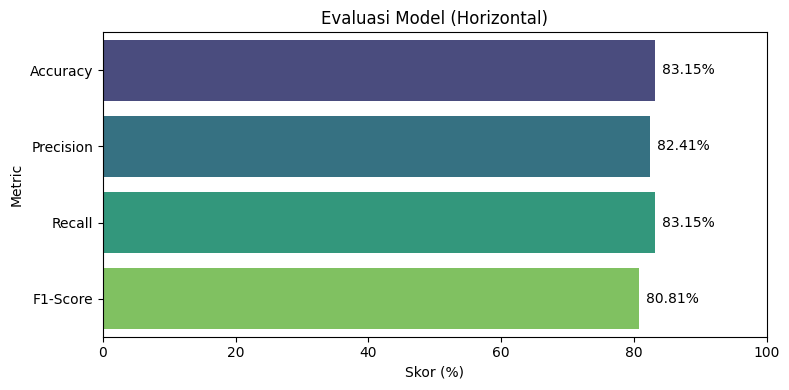

In [42]:
y_pred = loaded_model.predict(Test_X_Tfidf)

accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='weighted') * 100
recall = recall_score(y_test, y_pred, average='weighted') * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

scores_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [accuracy, precision, recall, f1]
})

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(data=scores_df, y='Metric', x='Score', palette='viridis')
plt.title('Evaluasi Model (Horizontal)')
plt.xlabel('Skor (%)')
plt.xlim(0, 100)
for index, row in scores_df.iterrows():
    plt.text(row.Score + 1, index, f"{row.Score:.2f}%", va='center')
plt.tight_layout()
plt.show()

In [43]:
report = classification_report(y_test, y_pred)
print(report) # print classification_report

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       875
           1       0.77      0.27      0.40       154
           2       0.77      0.65      0.70       152

    accuracy                           0.83      1181
   macro avg       0.79      0.63      0.67      1181
weighted avg       0.82      0.83      0.81      1181



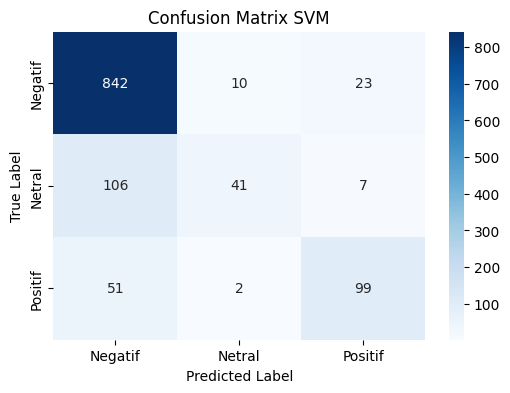

In [44]:
cm = confusion_matrix(y_test, y_pred)

label = ['Negatif', 'Netral', 'Positif']

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label, yticklabels=label)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix SVM')
plt.show()